In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from agents import BasicQLearningAgent, DeepQLearningAgent, Taxi

from IPython.display import Image


2024-10-28 16:18:59.369502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 16:18:59.572621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 16:18:59.640473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 16:18:59.660276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 16:18:59.801920: I tensorflow/core/platform/cpu_feature_guar

ImportError: cannot import name 'DeepQLearningAgent' from 'agents' (/home/jensen/ACIT/ACIT4610/Exam/ACIT4610_Portifolio_KMHS/problem_4/agents/__init__.py)

## Libs

- numpy
- matplotlib
- gym
- tensorflow / tensorflow[and-cuda]

## Documentations / References.

Documentation on gym / gymnasium can be found here: [https://gymnasium.farama.org/api/env/], it has good documentation on all the functions. - Do not use the one "showed" in exam paper: [https://www.gymlibrary.dev/index.html], since it has pretty bad documentation.

# [TASK-1] Overview of the Environment.

## Grid

The taxi can move on all nodes except $X$.

For each step it takes, it will be given $-1$ rewards, if successfully deliver passenger $+20$ reward points is granted. On failure on pickup and dropoff $-10$ reward points are granted.

$$
\begin{bmatrix}
\text{RED}_{11} & x_{12} & \text{X} & x_{14} & \text{GREEN}_{15} \\
x_{21} & x_{22} & \text{X} & x_{24} & x_{25} \\
x_{31} & x_{32} & x_{33} & x_{34} & x_{35} \\
x_{41} & \text{X} & x_{43} & x_{44} & x_{45} \\
\text{YELLOW}_{51} & \text{X} & x_53 & \text{BLUE}_{54} & x_{55}
\end{bmatrix}
$$

## Actions
0: move south

1: move north

2: move east

3: move west

4: pickup passenger

5: drop off passenger

## Observation space.

The taxi can dropoff passanger on (0)$\text{RED}_{11}$, (1)$\text{GREEN}_{15}$, (2)$\text{YELLOW}_{51}$, (3)$\text{BLUE}_{54}$.
That means that the passanger can be on all these stats, and additionally (4)$\text{in taxi}$.

The grid is **5x5** resulting in **25** different locations for the taxi.

$4_{destinations} * 5_{passanger_locations} * 25_{nodes} = 500_{states}$

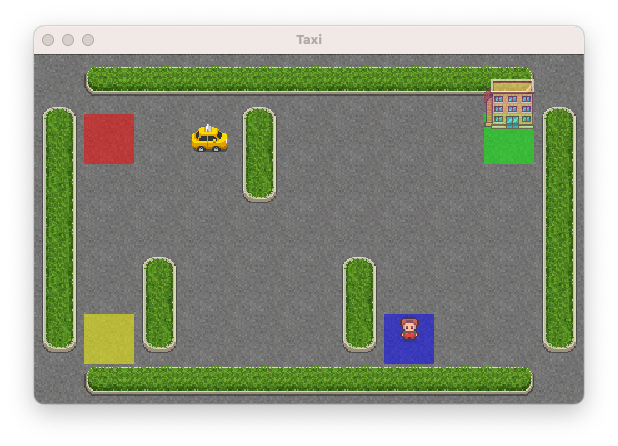

In [2]:
Image(filename='./static/SelfDrivingTaxi.png')

In [4]:
basic = BasicQLearningAgent(
    LEARNING_RATE=0.4,
    DISCOUNT_FACTOR=0.6,
    EPSILON=1.0,
    EPSILON_DECAY=0.0001,
    EPSILON_MIN=0.01
)

Taxi.run(basic, n_episodes=1000, is_training=True)
Taxi.run(basic, n_episodes=2, is_training=False)


/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [2]:
deep = DeepQLearningAgent(
    LEARNING_RATE=0.4,
    DISCOUNT_FACTOR=0.6,
    EPSILON=1.0,
    EPSILON_DECAY=0.0001,
    EPSILON_MIN=0.01,
    BATCH_SIZE=32
)

Taxi.run(deep, n_episodes=2000, is_training=True)
deep.plot_rewards()


I0000 00:00:1729584063.670255   29954 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729584063.697314   29954 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729584063.697442   29954 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729584063.698740   29954 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

End of episode: 0, reward: -722.0
Current Episode: 0, has_enough_data: True, has_rewards: True
Training the model.
Next State: 142
Current Q: [[ 0.00157884  0.14512688  0.05751334 -0.03519827 -0.02593222 -0.11281195]]
Target Prediction: [[-0.0284832   0.01755226 -0.0448065  -0.00559328 -0.01095323 -0.01268428]]
Target Q: [-0.0284832   0.01755226 -0.0448065  -0.00559328 -0.01095323 -0.01268428]
Next State: 422
Current Q: [[ 0.0692916   0.11246547  0.10803555  0.03101419 -0.02754773 -0.0293087 ]]
Target Prediction: [[-0.00656788  0.08332422 -0.04081687 -0.0670702  -0.02261805 -0.00895942]]
Target Q: [-0.00656788  0.08332422 -0.04081687 -0.0670702  -0.02261805 -0.00895942]
Next State: 362
Current Q: [[ 0.09345154  0.12362766  0.13080883  0.00879969  0.01637635 -0.15861079]]
Target Prediction: [[ 0.00604244 -0.07051752  0.03558425 -0.04690743 -0.03508842  0.0415357 ]]
Target Q: [ 0.00604244 -0.07051752  0.03558425 -0.04690743 -0.03508842  0.0415357 ]
Next State: 422
Current Q: [[ 0.0692916

/home/jensen/miniconda3/envs/acit4610_4/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
Taxi.run(deep, n_episodes=10, is_training=False)